# Montamos Unidad de Drive

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/Colab Notebooks/TP_Ind4

/content/drive/MyDrive/Colab Notebooks/TP_Ind4


In [ ]:
%cd drive/MyDrive/TP_Ind4

[Errno 2] No such file or directory: 'drive/MyDrive/TP_Ind4'
/content/drive/MyDrive/Colab Notebooks/TP_Ind4


In [3]:
%ls

 AnalisisExploratorio.ipynb
'best model'/
 data/
 Docs.gdoc
'model tunning'/
'TP 1 - Exploración, visualización de datos y Machine Learning.pdf'


# Datasets

In [9]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from joblib import dump, load

In [7]:
train = pd.read_csv("data/Train_full.csv", index_col = 0)
test = pd.read_csv("data/Test_full.csv", index_col = 0)
test.head()

,Age,Pdays,Previous,Subscription,Balance_pos_log,Last Contact Duration Log,Campaign Log,Job_admin.,Job_blue-collar,Job_management,Job_others,Job_retired,Job_services,Job_technician,Marital Status_divorced,Marital Status_married,Marital Status_single,Education_primary,Education_secondary,Education_tertiary,Last Contact Month_apr,Last Contact Month_aug,Last Contact Month_feb,Last Contact Month_jan,Last Contact Month_jul,Last Contact Month_jun,Last Contact Month_may,Last Contact Month_nov,Last Contact Month_other,"Last Contact Day Cat_(0, 7]","Last Contact Day Cat_(7, 14]","Last Contact Day Cat_(14, 21]","Last Contact Day Cat_(21, 31]",Housing Loan_yes,Personal Loan_yes,Age_60_True,Balance_neg_cat_True,Poutcome_failure,Poutcome_other,Poutcome_success,Poutcome_unknown
24456,58,229,5,0,-2.000000,2.387408,0.004321,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0
32687,38,-1,0,0,4.008132,2.683056,0.303196,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1
11452,52,-1,0,0,2.444045,2.837595,0.303196,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1
9583,41,180,2,0,3.690462,2.190360,0.004321,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0
23304,46,-1,0,0,2.240549,1.954291,0.004321,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1


In [18]:
P_vars = ["Pdays", "Previous", "Poutcome_failure", "Poutcome_other", "Poutcome_success", "Poutcome_unknown", "Subscription"]

X_train = train.drop("Subscription", axis = 1)
X_train_base = train.drop(P_vars, axis = 1)
y_train = train["Subscription"]

X_test = test.drop("Subscription", axis = 1)
X_test_base = test.drop(P_vars, axis = 1)
y_test = test["Subscription"]

# Models Import

In [10]:
rf_base = load('best model/rf_base.joblib')
rf_prev = load('best model/rf_prev.joblib')

# Base Model Evaluation

In [11]:
%cd best model

/content/drive/My Drive/Colab Notebooks/TP_Ind4/best model


In [12]:
from ModelCompare import modelCompareClass

In [13]:
%cd ..

/content/drive/My Drive/Colab Notebooks/TP_Ind4


In [14]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, make_scorer

def profit_mean(y_true, y_pred):
  mat = confusion_matrix(y_true=y_true, y_pred=y_pred)
  n = len(y_true)
  prof = 250 * mat[1,1] - 50 * mat[0,1] - 25 * mat[1,0]
  return prof/n

In [15]:
Comparison = modelCompareClass()

------------RF base------------

---------Train Metrics-----------
Accuracy = 0.8653415123274744
Sensibility = 0.8999243761028485
Specificity = 0.8607594936708861
AUC = 0.9394987269602657

Confusion Matrix
[[25772  4169]
 [  397  3570]]
-----------------------------------


-----------Test Metrics-----------
Accuracy = 0.8480934265239317
Sensibility = 0.7980332829046899
Specificity = 0.8547239755535517
AUC = 0.9094919530163287

Confusion Matrix
[[8531 1450]
 [ 267 1055]]


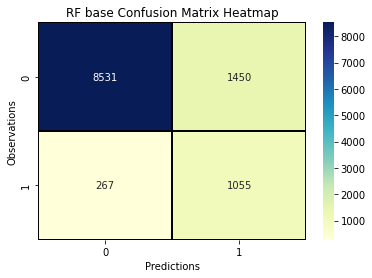

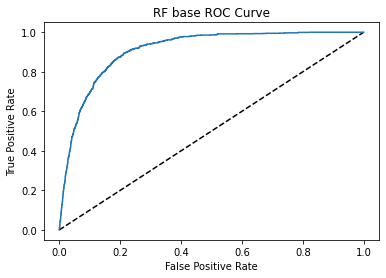

RF base Test Classification Report
              precision    recall  f1-score   support

           0       0.97      0.85      0.91      9981
           1       0.42      0.80      0.55      1322

    accuracy                           0.85     11303
   macro avg       0.70      0.83      0.73     11303
weighted avg       0.91      0.85      0.87     11303



In [19]:
Comparison.modelReportClass("RF base", rf_base, X_train_base, y_train, X_test_base, y_test, classReport=True)

In [54]:
print(profit_mean(y_test, rf_base.predict(X_test_base)))
print(profit_mean(y_test, rf_base.predict(X_test_base))*len(y_test))
print(confusion_matrix(y_test, rf_base.predict(X_test_base)))

16.329735468459702
184575.00000000003
[[8531 1450]
 [ 267 1055]]


# Modelo Cascada

TODA ESTA PARTE DE ENTRENAMIENTO SE HACE EN LOS RESPECTIVOS NOTEBOOKS DE TUNNING.

In [52]:
def cascadePrediction(data):
  # Creamos la lista de variables previas.
  P_vars = ["Pdays", "Previous", "Poutcome_failure", "Poutcome_other", "Poutcome_success", "Poutcome_unknown"]

  # Generamos el subset base sin las variables previas.
  # Este permite calcular la predicción de probabilidad de todas las observaciones.
  df_base = data.drop(P_vars, axis = 1)

  # Realizamos la predicción de probabilidad de todas las observaciones con el modelo base.
  base_pred = pd.Series(rf_base.predict_proba(df_base)[:,1], index=df_base.index, name="BasePrediction")
  # Agregamos la predicción de probabilidad al dataset.
  data = pd.merge(left=data, 
                  right=base_pred,
                  how='left',
                  left_index=True,
                  right_index=True)
  #data = pd.concat([data, base_pred], axis = 1)


  # Generamos el subset con variables y observaciones previas.
  # Este permite corregir la predicción de las observaciones que tienen variables previas.
  df_prev = data[data["Poutcome_unknown"] == 0]
  df_prev = df_prev[P_vars+["BasePrediction"]].drop("Poutcome_unknown", axis = 1)

  prev_pred = pd.Series(rf_prev.predict_proba(df_prev)[:,1], index=df_prev.index, name="PrevPrediction")
  data = pd.merge(left=data, 
                  right=prev_pred,
                  how='left',
                  left_index=True,
                  right_index=True)

  take_prediction = lambda s1, s2: s1 if np.isnan(s2) else s2
  data["Prediction Proba"] = data["BasePrediction"].combine(data["PrevPrediction"], take_prediction)
  data["Prediction"] = data["Prediction Proba"].apply(lambda x: 1 if x >= 0.5 else 0)

  return data["Prediction"]


In [67]:
len(rf_base.predict_proba(X_train_base)[:,1])
y_train

26828    0
12868    0
1405     0
1006     0
6125     0
        ..
10944    0
10974    1
17299    0
18378    0
36734    0
Name: Subscription, Length: 33908, dtype: int64

In [53]:
cascadePrediction(X_train)#.query("Poutcome_unknown == 0").iloc[:60]

26828    0
12868    0
1405     0
1006     0
6125     0
        ..
10944    1
10974    1
17299    0
18378    0
36734    1
Name: Prediction, Length: 33908, dtype: int64

In [55]:
print(profit_mean(y_test, rf_base.predict(X_test_base)))
print(profit_mean(y_test, rf_base.predict(X_test_base))*len(y_test))
print(confusion_matrix(y_test, rf_base.predict(X_test_base)))

16.329735468459702
184575.00000000003
[[8531 1450]
 [ 267 1055]]


In [57]:
print(profit_mean(y_test, cascadePrediction(X_test)))
print(profit_mean(y_test, cascadePrediction(X_test))*len(y_test))
print(confusion_matrix(y_test, cascadePrediction(X_test)))

17.749712465717067
200625.0
[[8423 1558]
 [ 189 1133]]


In [50]:
take_prediction = lambda s1, s2: s1 if np.isnan(s2) else s2
df_testings["Prediction Proba"] = df_testings["BasePrediction"].combine(df_testings["PrevPrediction"], take_prediction)
df_testings["Prediction"] = df_testings["Prediction Proba"].apply(lambda x: 1 if x >= 0.5 else 0)

In [51]:
df_testings

,Age,Pdays,Previous,Balance_pos_log,Last Contact Duration Log,Campaign Log,Job_admin.,Job_blue-collar,Job_management,Job_others,Job_retired,Job_services,Job_technician,Marital Status_divorced,Marital Status_married,Marital Status_single,Education_primary,Education_secondary,Education_tertiary,Last Contact Month_apr,Last Contact Month_aug,Last Contact Month_feb,Last Contact Month_jan,Last Contact Month_jul,Last Contact Month_jun,Last Contact Month_may,Last Contact Month_nov,Last Contact Month_other,"Last Contact Day Cat_(0, 7]","Last Contact Day Cat_(7, 14]","Last Contact Day Cat_(14, 21]","Last Contact Day Cat_(21, 31]",Housing Loan_yes,Personal Loan_yes,Age_60_True,Balance_neg_cat_True,Poutcome_failure,Poutcome_other,Poutcome_success,Poutcome_unknown,BasePrediction,PrevPrediction,Prediction Proba,Prediction
26828,46,-1,0,-2.000000,2.507869,0.699838,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0.089728,NaN,0.089728,0
12868,57,200,4,3.105851,1.643551,0.004321,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0.030235,0.066943,0.066943,0
1405,31,-1,0,1.477121,2.206853,0.303196,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0.128796,NaN,0.128796,0
1006,46,-1,0,2.071882,2.471306,0.004321,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0.104139,NaN,0.104139,0
6125,40,-1,0,3.064832,2.465398,0.903633,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,0,1,0.088234,NaN,0.088234,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10944,35,170,4,2.996512,3.151066,0.004321,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0.883046,0.753322,0.753322,1
10974,46,-1,0,2.432969,3.005614,1.462548,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0.872010,NaN,0.872010,1
17299,55,-1,0,1.342423,2.332459,0.004321,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0.079413,NaN,0.079413,0
18378,31,-1,0,1.591065,2.089940,0.699838,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0.024033,NaN,0.024033,0
